## Project Code

This section provides the full code used within this project. This is so that it can be run within this notebook if desired. Explaination about this code is made within the appropriate following sections and the code being explained will be copied into that section to assist with explaination.

### Imports

In [16]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import glob
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

### UNet class
Below is our implementation of a Convolutional Neural Network based UNet architecture.

In [17]:
class Unet(torch.nn.Module):
    def __init__(self, image_channels, hidden_size=16, n_classes=4):
        super(Unet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Encoder
        self.conv1_1 = nn.Conv2d(in_channels=image_channels, out_channels=hidden_size, kernel_size=3, stride=1,
                                 padding=1)
        self.batch1_1 = nn.BatchNorm2d(hidden_size, affine=True)
        self.conv1_2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.batch1_2 = nn.BatchNorm2d(hidden_size, affine=True)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2_1 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                 padding=1)
        self.batch2_1 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.conv2_2 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                 padding=1)
        self.batch2_2 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3_1 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                 padding=1)
        self.batch3_1 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.conv3_2 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                 padding=1)
        self.batch3_2 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout3 = nn.Dropout(0.2)

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 8, kernel_size=3,
                                         stride=1, padding=1)
        self.bottleneck_batch = nn.BatchNorm2d(hidden_size * 8, affine=True)

        # Decoder
        self.upsample_3 = nn.ConvTranspose2d(in_channels=hidden_size * 8, out_channels=hidden_size * 4, kernel_size=2,
                                             stride=2)
        self.upconv3_1 = nn.Conv2d(in_channels=hidden_size * 8, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch3_1 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.upconv3_2 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch3_2 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.dropout4 = nn.Dropout(0.2)

        self.upsample_2 = nn.ConvTranspose2d(in_channels=hidden_size * 4, out_channels=hidden_size * 2, kernel_size=2,
                                             stride=2)
        self.upconv2_1 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch2_1 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.upconv2_2 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch2_2 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.dropout5 = nn.Dropout(0.2)

        self.upsample_1 = nn.ConvTranspose2d(in_channels=hidden_size * 2, out_channels=hidden_size, kernel_size=2,
                                             stride=2)
        self.upconv1_1 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch1_1 = nn.BatchNorm2d(hidden_size, affine=True)
        self.upconv1_2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch1_2 = nn.BatchNorm2d(hidden_size, affine=True)
        self.dropout6 = nn.Dropout(0.2)

        # Final Layer
        self.conv_out = nn.Conv2d(in_channels=hidden_size, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        self.enc_layer1 = F.leaky_relu(self.batch1_1(self.conv1_1(x)))
        self.enc_layer1 = F.leaky_relu(self.batch1_2(self.conv1_2(self.enc_layer1)))
        self.enc_layer1_pool = self.dropout1(self.pool1(self.enc_layer1))

        self.enc_layer2 = F.leaky_relu(self.batch2_1(self.conv2_1(self.enc_layer1_pool)))
        self.enc_layer2 = F.leaky_relu(self.batch2_2(self.conv2_2(self.enc_layer2)))
        self.enc_layer2_pool = self.dropout2(self.pool2(self.enc_layer2))

        self.enc_layer3 = F.leaky_relu(self.batch3_1(self.conv3_1(self.enc_layer2_pool)))
        self.enc_layer3 = F.leaky_relu(self.batch3_2(self.conv3_2(self.enc_layer3)))
        self.enc_layer3_pool = self.dropout3(self.pool3(self.enc_layer3))

        self.bottleneck_layer = F.leaky_relu(self.bottleneck_batch(self.bottleneck_conv(self.enc_layer3_pool)))

        self.up3 = torch.cat((self.upsample_3(self.bottleneck_layer), self.enc_layer3), 1)
        self.up3 = F.leaky_relu(self.batch3_1(self.upconv3_1(self.up3)))
        self.up3 = self.dropout4(F.leaky_relu(self.batch3_2(self.upconv3_2(self.up3))))

        self.up2 = torch.cat((self.upsample_2(self.up3), self.enc_layer2), 1)
        self.up2 = F.leaky_relu(self.batch2_1(self.upconv2_1(self.up2)))
        self.up2 = self.dropout5(F.leaky_relu(self.batch2_2(self.upconv2_2(self.up2))))

        self.up1 = torch.cat((self.upsample_1(self.up2), self.enc_layer1), 1)
        self.up1 = F.leaky_relu(self.batch1_1(self.upconv1_1(self.up1)))
        self.up1 = self.dropout6(F.leaky_relu(self.batch1_2(self.upconv1_2(self.up1))))

        self.out = self.conv_out(self.up1)

        return self.out

### DeepLabV3 class and associated classes
Below is our implementation of a DeepLabV3 architecture. The "Block", "ResNet18" and "ASPP" classes are required by the "DeepLabV3" class.

In [18]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, channels, dilation=1):
        super(Block, self).__init__()

        out_channels = channels

        self.conv1 = nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation,
                               bias=False)
        self.batch1 = nn.BatchNorm2d(channels)

        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation,
                               bias=False)
        self.batch2 = nn.BatchNorm2d(channels)

        if in_channels != channels:
            conv = nn.Conv2d(in_channels, channels, kernel_size=1, stride=1, bias=False)
            batch = nn.BatchNorm2d(channels)
            self.downsample = nn.Sequential(conv, batch)
        else:
            self.downsample = nn.Sequential()

    def forward(self, x):
        out = F.relu(self.batch1(self.conv1(x)))
        out = self.batch2(self.conv2(out))
        out = out + self.downsample(x)
        out = F.relu(out)
        return out


class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        # Use ResNet18
        resnet = models.resnet18()  # 18 convolution layers
        # load pretrained model
        resnet.load_state_dict(torch.load("./ResnetModels/resnet18-f37072fd.pth"))
        # remove fully connected layer, avg pool, layer4 and layer5
        self.resnet = nn.Sequential(*list(resnet.children())[:-4])

        blocks = []
        blocks.append(Block(in_channels=128, channels=256, dilation=2))
        blocks.append(Block(in_channels=256, channels=256, dilation=2))
        self.layer4 = nn.Sequential(*blocks)
        blocks = []
        blocks.append(Block(in_channels=256, channels=512, dilation=4))
        blocks.append(Block(in_channels=512, channels=512, dilation=4))
        self.layer5 = nn.Sequential(*blocks)

    def forward(self, x):
        out = self.resnet(x)
        out = self.layer4(out)
        out = self.layer5(out)
        return out


class ASPP(torch.nn.Module):
    def __init__(self, num_classes, in_scale=1):
        super(ASPP, self).__init__()

        self.conv1_1 = nn.Conv2d(in_scale * 512, 256, kernel_size=1)
        self.batch1_1 = nn.BatchNorm2d(256)
        self.conv1_2 = nn.Conv2d(in_scale * 512, 256, kernel_size=3, stride=1, padding=6, dilation=6)
        self.batch1_2 = nn.BatchNorm2d(256)
        self.conv1_3 = nn.Conv2d(in_scale * 512, 256, kernel_size=3, stride=1, padding=12, dilation=12)
        self.batch1_3 = nn.BatchNorm2d(256)
        self.conv1_4 = nn.Conv2d(in_scale * 512, 256, kernel_size=3, stride=1, padding=18, dilation=18)
        self.batch1_4 = nn.BatchNorm2d(256)

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.conv2 = nn.Conv2d(in_scale * 512, 256, kernel_size=1)
        self.batch2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(1280, 256, kernel_size=1)
        self.batch3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # get the height and width of feature map for upsampling
        h = x.size()[2]
        w = x.size()[3]

        out1 = F.leaky_relu(self.batch1_1(self.conv1_1(x)))
        out2 = F.leaky_relu(self.batch1_2(self.conv1_2(x)))
        out3 = F.leaky_relu(self.batch1_3(self.conv1_3(x)))
        out4 = F.leaky_relu(self.batch1_4(self.conv1_4(x)))

        out = self.pool(x)
        out = F.leaky_relu(self.batch2(self.conv2(out)))

        # Upsampling step
        out_img = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
        out = torch.cat([out1, out2, out3, out4, out_img], 1)
        out = F.leaky_relu(self.batch3(self.conv3(out)))
        out = self.conv4(out)

        return out


class DeepLabV3(torch.nn.Module):
    def __init__(self, n_classes=4):
        super(DeepLabV3, self).__init__()

        # Load resnet model
        # Pretrained for 18 Convolution layers
        self.resnet = ResNet18()
        # Load ASPP model
        self.aspp = ASPP(num_classes=n_classes, in_scale=1)

    def forward(self, x):
        # get the height and width of feature map for upsampling
        h = x.size()[2]
        w = x.size()[3]

        feature_map = self.resnet(x)
        out = self.aspp(feature_map)
        # Upsampling step
        out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
        return out

### UNet2 class
Below is a second implementation of a Convolutional Neural Network based UNet architecture. This UNet2 model has 4 stages, as opposed to the original UNet model which only had 3.

In [19]:
class Unet2(torch.nn.Module):
    def __init__(self, image_channels=1, hidden_size=16, n_classes=4):
        super(Unet2, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Encoder
        self.conv1_1 = nn.Conv2d(in_channels=image_channels, out_channels=hidden_size, kernel_size=3, stride=1,
                                 padding=1)
        self.batch1_1 = nn.BatchNorm2d(hidden_size, affine=True)
        self.conv1_2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1)
        self.batch1_2 = nn.BatchNorm2d(hidden_size, affine=True)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout1 = nn.Dropout(0.1)

        self.conv2_1 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                 padding=1)
        self.batch2_1 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.conv2_2 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                 padding=1)
        self.batch2_2 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout2 = nn.Dropout(0.1)

        self.conv3_1 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                 padding=1)
        self.batch3_1 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.conv3_2 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                 padding=1)
        self.batch3_2 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout3 = nn.Dropout(0.1)

        self.conv4_1 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 8, kernel_size=3, stride=1,
                                 padding=1)
        self.batch4_1 = nn.BatchNorm2d(hidden_size * 8, affine=True)
        self.conv4_2 = nn.Conv2d(in_channels=hidden_size * 8, out_channels=hidden_size * 8, kernel_size=3, stride=1,
                                 padding=1)
        self.batch4_2 = nn.BatchNorm2d(hidden_size * 8, affine=True)
        self.pool4 = nn.MaxPool2d(3, 2, padding=1)
        self.dropout4 = nn.Dropout(0.1)

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=hidden_size * 8, out_channels=hidden_size * 16, kernel_size=3,
                                         stride=1, padding=1)
        self.bottleneck_batch = nn.BatchNorm2d(hidden_size * 16, affine=True)

        # Decoder
        self.upsample_4 = nn.ConvTranspose2d(in_channels=hidden_size * 16, out_channels=hidden_size * 8, kernel_size=2,
                                             stride=2)
        self.upconv4_1 = nn.Conv2d(in_channels=hidden_size * 16, out_channels=hidden_size * 8, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch4_1 = nn.BatchNorm2d(hidden_size * 8, affine=True)
        self.upconv4_2 = nn.Conv2d(in_channels=hidden_size * 8, out_channels=hidden_size * 8, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch4_2 = nn.BatchNorm2d(hidden_size * 8, affine=True)
        self.dropout5 = nn.Dropout(0.1)

        self.upsample_3 = nn.ConvTranspose2d(in_channels=hidden_size * 8, out_channels=hidden_size * 4, kernel_size=2,
                                             stride=2)
        self.upconv3_1 = nn.Conv2d(in_channels=hidden_size * 8, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch3_1 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.upconv3_2 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 4, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch3_2 = nn.BatchNorm2d(hidden_size * 4, affine=True)
        self.dropout6 = nn.Dropout(0.1)

        self.upsample_2 = nn.ConvTranspose2d(in_channels=hidden_size * 4, out_channels=hidden_size * 2, kernel_size=2,
                                             stride=2)
        self.upconv2_1 = nn.Conv2d(in_channels=hidden_size * 4, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch2_1 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.upconv2_2 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size * 2, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch2_2 = nn.BatchNorm2d(hidden_size * 2, affine=True)
        self.dropout7 = nn.Dropout(0.1)

        self.upsample_1 = nn.ConvTranspose2d(in_channels=hidden_size * 2, out_channels=hidden_size, kernel_size=2,
                                             stride=2)
        self.upconv1_1 = nn.Conv2d(in_channels=hidden_size * 2, out_channels=hidden_size, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch1_1 = nn.BatchNorm2d(hidden_size, affine=True)
        self.upconv1_2 = nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1,
                                   padding=1)
        self.upbatch1_2 = nn.BatchNorm2d(hidden_size, affine=True)
        self.dropout8 = nn.Dropout(0.1)

        # Final Layer
        self.conv_out = nn.Conv2d(in_channels=hidden_size, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        self.enc_layer1 = F.leaky_relu(self.batch1_1(self.conv1_1(x)))
        self.enc_layer1 = F.leaky_relu(self.batch1_2(self.conv1_2(self.enc_layer1)))
        self.enc_layer1_pool = self.dropout1(self.pool1(self.enc_layer1))

        self.enc_layer2 = F.leaky_relu(self.batch2_1(self.conv2_1(self.enc_layer1_pool)))
        self.enc_layer2 = F.leaky_relu(self.batch2_2(self.conv2_2(self.enc_layer2)))
        self.enc_layer2_pool = self.dropout2(self.pool2(self.enc_layer2))

        self.enc_layer3 = F.leaky_relu(self.batch3_1(self.conv3_1(self.enc_layer2_pool)))
        self.enc_layer3 = F.leaky_relu(self.batch3_2(self.conv3_2(self.enc_layer3)))
        self.enc_layer3_pool = self.dropout3(self.pool3(self.enc_layer3))

        self.enc_layer4 = F.leaky_relu(self.batch4_1(self.conv4_1(self.enc_layer3_pool)))
        self.enc_layer4 = F.leaky_relu(self.batch4_2(self.conv4_2(self.enc_layer4)))
        self.enc_layer4_pool = self.dropout4(self.pool4(self.enc_layer4))

        self.bottleneck_layer = F.leaky_relu(self.bottleneck_batch(self.bottleneck_conv(self.enc_layer4_pool)))

        self.up4 = torch.cat((self.upsample_4(self.bottleneck_layer), self.enc_layer4), 1)
        self.up4 = F.leaky_relu(self.batch4_1(self.upconv4_1(self.up4)))
        self.up4 = self.dropout5(F.leaky_relu(self.batch4_2(self.upconv4_2(self.up4))))

        self.up3 = torch.cat((self.upsample_3(self.up4), self.enc_layer3), 1)
        self.up3 = F.leaky_relu(self.batch3_1(self.upconv3_1(self.up3)))
        self.up3 = self.dropout6(F.leaky_relu(self.batch3_2(self.upconv3_2(self.up3))))

        self.up2 = torch.cat((self.upsample_2(self.up3), self.enc_layer2), 1)
        self.up2 = F.leaky_relu(self.batch2_1(self.upconv2_1(self.up2)))
        self.up2 = self.dropout7(F.leaky_relu(self.batch2_2(self.upconv2_2(self.up2))))

        self.up1 = torch.cat((self.upsample_1(self.up2), self.enc_layer1), 1)
        self.up1 = F.leaky_relu(self.batch1_1(self.upconv1_1(self.up1)))
        self.up1 = self.dropout8(F.leaky_relu(self.batch1_2(self.upconv1_2(self.up1))))

        self.out = self.conv_out(self.up1)

        return self.out

### DatasetClass class
Below is the DatasetClass class that we used to manage the loading in of training/evaluation data.

In [20]:
class DatasetClass(Dataset):
    def __init__(self, root='', flag='train', aug=True):
        super(DatasetClass, self).__init__()
        self.flag = flag
        self.aug = aug
        self.img_files = glob.glob(os.path.join(root, 'image', '*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root, 'mask', basename[:-4] + '_mask.png'))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if self.flag == 'test':
            data = np.expand_dims(data, 0)
            data_tensor = torch.from_numpy(data).float() / 255
            return data_tensor  # Normalize pixels to lie between [0, 1]
        else:
            mask_path = self.mask_files[index]
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            if self.flag == 'train' and self.aug:
                # provide some transformations on images to increase the training data variability
                rand_int = np.random.randint(4)
                if rand_int == 0:  # No augmentation
                    pass
                elif rand_int == 1:  # Horizontal flip
                    data, label = cv2.flip(data, 1), cv2.flip(label, 1)
                elif rand_int == 2:  # Vertical flip
                    data, label = cv2.flip(data, 0), cv2.flip(label, 0)
                else:  # Rotation
                    angle = np.random.randint(-10, 10)
                    w, h = data.shape[1], data.shape[0]
                    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
                    data, label = cv2.warpAffine(data, M, (w, h)), cv2.warpAffine(label, M, (w, h))

            data = np.expand_dims(data, 0)
            data_tensor, label_tensor = torch.from_numpy(data).float() / 255, torch.from_numpy(label).long()
            return data_tensor, label_tensor  # Normalize pixels to lie between [0, 1]

    def __len__(self):
        return len(self.img_files)

### Loss function classes
Below are various loss function classes that we implemented to allow us to more easily test for which was most effective.

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, weights, alpha=0.9, gamma=2, beta=0.9):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.betas = torch.ones((weights.shape[0])) * beta
        self.weights = (1 - self.betas) / (1 - self.betas ** torch.from_numpy(weights))
        self.CEloss = nn.CrossEntropyLoss(self.weights.float().to(self.device)).to(self.device)

    def forward(self, preds, targets):
        ce_loss = self.CEloss(preds, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        # focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets):
        preds = F.softmax(preds, 1)
        targets = F.one_hot(targets).permute(0, 3, 1, 2)
        dice_loss = 2 * torch.sum(preds * targets, axis=[2, 3]) / (
                    torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3]))
        return 1 - dice_loss.mean()


class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2):
        super(DiceFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.CEloss = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        # focal loss
        ce_loss = self.CEloss(preds, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()

        # dice loss
        preds = F.softmax(preds, 1)
        targets = F.one_hot(targets).permute(0, 3, 1, 2)
        dice_loss = 2 * torch.sum(preds * targets, axis=[2, 3]) / (
                    torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3]))
        dice_loss = 1 - dice_loss.mean()

        loss = focal_loss + dice_loss
        return loss


class CEDiceLoss(nn.Module):
    def __init__(self):
        super(CEDiceLoss, self).__init__()
        self.CEloss = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.CEloss(preds, targets)
        preds = F.softmax(preds, 1)
        targets = F.one_hot(targets).permute(0, 3, 1, 2)
        dice_loss = 2 * torch.sum(preds * targets, axis=[2, 3]) / (
                    torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3]))
        dice_loss = 1 - dice_loss.mean()
        return ce_loss + dice_loss


class WeightedDiceLoss(nn.Module):
    def __init__(self, weights, beta=0.9):
        super(WeightedDiceLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.betas = torch.ones((weights.shape[0])) * beta
        self.weights = (1 - self.betas) / (1 - self.betas ** torch.from_numpy(weights))
        self.CEloss = nn.CrossEntropyLoss(self.weights.float().to(self.device)).to(self.device)

    def forward(self, preds, targets):
        ce_loss = self.CEloss(preds, targets)
        preds = F.softmax(preds, 1)
        targets = F.one_hot(targets).permute(0, 3, 1, 2)
        dice_loss = 2 * torch.sum(preds * targets, axis=[2, 3]) / (
                    torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3]))
        dice_loss = 1 - dice_loss.mean()
        return ce_loss + dice_loss

### Evaluation Metrics class
This class assisted us in making comparisons between different model implementations and loss functions etc.

In [22]:
class Evaluation_Metrics():
    def __init__(self):
        self.se = nn.MSELoss()
        pass

    def multi_class_dice_score(self, preds, targets):
        dice_score = 2 * torch.sum(preds * targets, axis=[2, 3]) / (torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3]))
        return dice_score.mean(axis=0)

    def accuracy(self, preds, targets):
        pred = F.one_hot(torch.argmax(preds, axis=1)).permute(0, 3, 1, 2)
        acc = (pred==targets).float().mean(axis=[2,3]).mean(axis=0)
        return acc

    def iou(self, preds, targets):
        intersection = torch.sum(preds * targets, axis=[2, 3])
        total_area = torch.sum(preds, axis=[2, 3]) + torch.sum(targets, axis=[2, 3])
        dice_score = intersection / (total_area - intersection)
        return dice_score.mean(axis=0)

    def evaluate(self, preds, targets):
        preds = F.softmax(preds, 1)
        targets = F.one_hot(targets).permute(0, 3, 1, 2)
        dice_score = self.multi_class_dice_score(preds, targets)
        accuracy = self.accuracy(preds, targets)
        iou = self.iou(preds, targets)
        return [dice_score.cpu().numpy(), accuracy.cpu().numpy(), iou.cpu().numpy()]

### Main class
This class is the main entry and execution point for the program.

In [23]:
class Main:
    def __init__(self, train=True, test=True, eval=True, train__dir='./data/train', test_dir='./data/test',
                 val_dir="./data/val", epochs=3, learning_rate=1e-3, reg=1e-3, batch_size=16, num_workers=2,
                 load_model_params=True, save_model_params=True, saved_params_path="models/focalloss_earlystop.pt",
                 save_freq=5, dataset_debug=True, loss_fn='Focal', tensorboard_log='runs/test_1',
                 model_arch='DeepLabV3', test_path='test_results', aug=True, early_stop=True, use_tensorboard=False):

        # initialize class properties from arguments
        self.train_dir, self.test_dir = train__dir, test_dir
        self.epochs, self.lr, self.reg = epochs, learning_rate, reg
        self.batch_size, self.num_workers = batch_size, num_workers
        self.val_dir = val_dir
        self.save_model_params = save_model_params
        self.saved_params_path = saved_params_path
        self.save_freq = save_freq
        self.model_arch = model_arch
        self.test_path = test_path
        self.aug = aug
        self.early_stop = early_stop
        self.use_tensorboard=use_tensorboard
        if not os.path.exists(self.test_path):
            os.makedirs(self.test_path)

        # determine if GPU can be used and assign to 'device' class property
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # set properties relating to dataset
        self.train_dataset_size = len(glob.glob(os.path.join(self.train_dir, 'image', "*.png")))
        self.train_dataset = DatasetClass(self.train_dir, flag='train', aug=self.aug)
        self.val_dataset = DatasetClass(self.val_dir, flag='val')
        self.test_dataset = DatasetClass(self.test_dir, flag='test')

        # load data ready for training
        self.train_dataloader = DataLoader(self.train_dataset, self.batch_size, shuffle=True,
                                           num_workers=self.num_workers, pin_memory=True, drop_last=True)
        self.val_dataloader = DataLoader(self.val_dataset, self.batch_size, shuffle=True,
                                         num_workers=1, pin_memory=True, drop_last=False)
        self.test_dataloader = DataLoader(self.test_dataset, self.batch_size, shuffle=False,
                                          num_workers=1, pin_memory=True, drop_last=False)

        # create the model
        if self.model_arch == 'Unet':
            self.model = Unet(image_channels=1, hidden_size=32).to(self.device)
        elif self.model_arch == 'DeepLabV3':
            self.model = DeepLabV3(n_classes=4).to(self.device)

        # load model parameters from file
        if load_model_params and os.path.isfile(saved_params_path):
            self.model.load_state_dict(torch.load(saved_params_path, map_location=self.device))

        # set loss function
        if loss_fn == 'CE':
            self.loss = nn.CrossEntropyLoss()
        elif loss_fn == 'Focal':
            self.loss = FocalLoss(self.dataset_properties())
        elif loss_fn == 'Dice':
            self.loss = DiceLoss()
        elif loss_fn == 'DiceFocal':
            self.loss = DiceFocalLoss(alpha=0.99)
        elif loss_fn == 'CEDice':
            self.loss = CEDiceLoss()
        elif loss_fn == 'WeightedDice':
            self.loss = WeightedDiceLoss(self.dataset_properties())

        # set optimiser
        self.optim = optim.Adam(self.model.parameters(), self.lr, weight_decay=self.reg)

        # evaluation metrics
        self.eval_metrics = Evaluation_Metrics()

        if dataset_debug:
            self.data_viz()  # Visualize the training data alongside it's masks

        if train:
            if self.use_tensorboard:
                from torch.utils.tensorboard import SummaryWriter
                self.writer = SummaryWriter(tensorboard_log)
                print("TENSORBOARD")
            self.train()  # carry out training
            if self.use_tensorboard:
                self.writer.close()

        if test:
            self.model_test()  # Forward pass of model

        if eval:
            self.test_preds_generate()  # Save masks
            self.submission_converter(self.test_path, "")  # Create csv file
            self.evaluate()  # Evaluate dice score

    def dataset_properties(self):
        """Find out statistics about number of pixels in the dataset belonging to each class"""
        class_scores = {}
        mask = None
        for i in range(self.train_dataset_size):
            mask = cv2.imread(os.path.join(self.train_dir, 'mask', 'cmr{}_mask.png'.format(str(i + 1))),
                              cv2.IMREAD_UNCHANGED)
            for idx in np.unique(mask):
                pix_count = np.where(mask == idx)
                if idx not in class_scores.keys():
                    class_scores[idx] = pix_count[0].shape[0]  # Create new keys in dict
                else:
                    class_scores[idx] += pix_count[0].shape[0]  # Update already existing key
        plot_list = []
        if mask is not None:
            for idx in class_scores.keys():
                class_scores[idx] /= (mask.shape[0] * mask.shape[1] * self.train_dataset_size)
                plot_list.append(class_scores[idx] * 100)  # Convert to percentage

        return np.array(plot_list)

    def data_viz(self):
        """Displays each training data image with its corresponding masks"""
        for i in range(self.train_dataset_size):
            image = cv2.imread(os.path.join(self.train_dir, 'image', 'cmr{}.png'.format(str(i + 1))),
                               cv2.IMREAD_UNCHANGED)
            mask = cv2.imread(os.path.join(self.train_dir, 'mask', 'cmr{}_mask.png'.format(str(i + 1))),
                              cv2.IMREAD_UNCHANGED)
            self.dummy_mask = np.zeros((image.shape[0], image.shape[1], len(np.unique(mask))))
            # returns True when visualization should continue
            if self.mask_prepare(image, mask):
                pass
            else:
                break

    def mask_prepare(self, img, mask):
        """ Format each features image to be white on the feature and black everywhere else.
			Then combine into one image and display."""
        # filter out all pixels that are not 255 for each feature
        for i in range(len(np.unique(mask))):
            self.dummy_mask[:, :, i][np.where(mask == i)] = 255

        imgs = [img.astype(np.uint8)]
        for i in range(len(np.unique(mask))):
            imgs.append(self.dummy_mask[:, :, i].astype(np.uint8))

        # combine each feature map into one image
        out = np.hstack(imgs)

        # display image
        cv2.imshow("Feature maps", out)

        # quit when q key is pressed
        k = cv2.waitKey()
        if k == ord('q'):
            return False
        return True

    def train(self):
        """Carry out training on the model"""
        train_losses = []
        val_losses = []
        early_stopping_check = None
        early_stopping_freq = 3
        check = 0
        self.model.train()
        for epoch in range(self.epochs):
            train_epoch_loss = 0
            val_epoch_loss = 0
            val_scores = []

            # training batch
            for batch_idx1, (data, label) in enumerate(self.train_dataloader):
                data, label = data.to(self.device), label.to(self.device)
                if self.model_arch == 'DeepLabV3':
                    data = data.expand(-1, 3, -1, -1)
                out = self.model(data)  # forward pass
                loss = self.loss(out, label)  # loss calculation
                self.optim.zero_grad()  # back-propogation
                loss.backward()
                self.optim.step()
                train_epoch_loss += loss

            # validation batch, only used for tracking loss reduction over time
            for batch_idx2, (data, label) in enumerate(self.val_dataloader):
                data, label = data.to(self.device), label.to(self.device)
                if self.model_arch == 'DeepLabV3':
                    data = data.expand(-1, 3, -1, -1)
                with torch.no_grad():
                    out = self.model(data)  # forward pas
                    loss = self.loss(out, label)  # val loss calculation
                    val_epoch_loss += loss
                    val_score = self.eval_metrics.evaluate(out, label)
                    val_scores.append(val_score)

            train_epoch_loss = train_epoch_loss.cpu().item() / max(1, batch_idx1)
            val_epoch_loss = val_epoch_loss.cpu().item() / max(1, batch_idx2)
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            val_scores = np.mean(np.array(val_scores), axis=0)

            if self.use_tensorboard:
                self.writer.add_scalar("Train Loss", train_epoch_loss, epoch)
                self.writer.add_scalar("Val Loss", val_epoch_loss, epoch)
                self.writer.add_scalars('Mean Scores', {'Dice Score': np.mean(val_scores[0]),
                                                    'Accuracy': np.mean(val_scores[1]),
                                                    'IOU': np.mean(val_scores[2])}, epoch)

                for i in range(val_scores.shape[1]):
                    self.writer.add_scalars('Class{}'.format(str(i)), {'Dice Score': val_scores[0][i],
                                                                   'Accuracy': val_scores[1][i],
                                                                   'IOU': val_scores[2][i]}, epoch)

            print("EPOCH {}: ".format(epoch), train_epoch_loss, val_epoch_loss)

            # save model parameters to file
            if ((epoch + 1) % self.save_freq == 0) and self.save_model_params:
                print("Saving model")
                torch.save(self.model.state_dict(), self.saved_params_path)

            # early stopping
            if self.early_stop:
                if epoch == 0:
                    early_stopping_check = np.mean(val_scores)

                elif epoch % early_stopping_freq == 0:
                    mean_scores = np.mean(val_scores)
                    if np.mean(mean_scores) < np.mean(early_stopping_check):
                        check += 1
                        print("Check", check)
                        if check == 3:
                            print("EARLY STOPPING")
                            break
                    early_stopping_check = np.mean(val_scores)

    def model_test(self):
        """display performance on each of validation data"""
        self.model.eval()
        for i in range(1, 21):
            iStr = "0" + str(i) if i < 10 else str(i)

            # load in base image
            img = cv2.imread(os.path.join(self.val_dir, 'image', 'cmr1{}.png'.format(iStr)), cv2.IMREAD_UNCHANGED)

            # load in correct mask
            img_mask = cv2.imread(os.path.join(self.val_dir, 'mask', 'cmr1{}_mask.png'.format(iStr)),
                                  cv2.IMREAD_UNCHANGED)

            # convert base image to tensor and normalize pixels to lie between [0, 1]
            self.img_tensor = torch.from_numpy(np.expand_dims(np.expand_dims(img.astype(np.uint8), 0), 0)).to(
                self.device).float() / 255

            with torch.no_grad():
                # process through model
                if self.model_arch == 'DeepLabV3':
                    self.img_tensor = self.img_tensor.expand(-1, 3, -1, -1)
                out = self.model(self.img_tensor)
                out = F.softmax(out, 1).permute(0, 2, 3, 1)
                out = self.one_hot(out).cpu().numpy()[0] * 255
                # stack processed images into one image
                out_img = np.hstack((img.astype(np.uint8),
                                     out[:, :, 0].astype(np.uint8),  # background
                                     out[:, :, 1].astype(np.uint8),  # right ventricle
                                     out[:, :, 2].astype(np.uint8),  # myocardium
                                     out[:, :, 3].astype(np.uint8)))  # left ventricle

                # process mask to produce mirror stacked image as above, with features in the same places
                out_actual = np.zeros((img_mask.shape[0], img_mask.shape[1], len(np.unique(img_mask))))
                for i in range(len(np.unique(img_mask))):
                    out_actual[:, :, i][np.where(img_mask == i)] = 255
                out_actual_img = np.hstack((img.astype(np.uint8),
                                            out_actual[:, :, 0].astype(np.uint8),  # background
                                            out_actual[:, :, 1].astype(np.uint8),  # right ventricle
                                            out_actual[:, :, 2].astype(np.uint8),  # myocardium
                                            out_actual[:, :, 3].astype(np.uint8)))  # left ventricle

                # display both images
                cv2.imshow("MODEL OUTPUT", out_img)
                cv2.imshow("ACTUAL MASK", out_actual_img)
                k = cv2.waitKey()
                if k == ord('q'):
                    exit()

    def test_preds_generate(self):
        """display performance on each of validation data"""
        self.model.eval()
        self.test_data = glob.glob(os.path.join(self.test_dir, 'image', "*.png"))
        for file in self.test_data:
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            self.img_tensor = torch.from_numpy(np.expand_dims(np.expand_dims(img.astype(np.uint8), 0), 0)).to(
                self.device).float() / 255
            with torch.no_grad():
                if self.model_arch == 'DeepLabV3':
                    self.img_tensor = self.img_tensor.expand(-1, 3, -1, -1)
                out = self.model(self.img_tensor)  # forward pass
                out = F.softmax(out, 1).permute(0, 2, 3, 1)
                out = self.un_one_hot(out).cpu().numpy()[0]
                path = self.test_path + "/" + file.split("\\")[-1].split(".")[0] + "_mask.png"
                cv2.imwrite(path, out)

    def evaluate(self):
        """display performance on each of validation data"""
        self.model.eval()
        dice_scores = []
        for i in range(1, 21):
            iStr = "0" + str(i) if i < 10 else str(i)

            # load in base image
            img = cv2.imread(os.path.join(self.val_dir, 'image', 'cmr1{}.png'.format(iStr)), cv2.IMREAD_UNCHANGED)

            # load in correct mask
            img_mask = cv2.imread(os.path.join(self.val_dir, 'mask', 'cmr1{}_mask.png'.format(iStr)),
                                  cv2.IMREAD_UNCHANGED)

            # convert base image to tensor
            self.img_tensor = torch.from_numpy(np.expand_dims(np.expand_dims(img.astype(np.uint8), 0), 0)).to(
                self.device).float()
            self.img_mask = torch.from_numpy(np.expand_dims(img_mask.astype(np.uint8), 0)).to(
                self.device).float()
            if self.model_arch == 'DeepLabV3':
                self.img_tensor = self.img_tensor.expand(-1, 3, -1, -1)
            with torch.no_grad():
                # process through model
                out = self.model(self.img_tensor)
                out = F.softmax(out, 1).permute(0, 2, 3, 1)
                out = self.un_one_hot(out)
                dice_scores.append(self.categorical_dice(out.permute(1, 2, 0), self.img_mask.permute(1, 2, 0)))
        dice_scores_norm = np.sum(np.array(dice_scores), axis=0) / len(dice_scores)
        num_classes = dice_scores_norm.shape[0]
        plt.bar(["Class " + str(i) for i in range(num_classes)], dice_scores_norm, width=0.1)
        plt.show()
        print(dice_scores_norm, num_classes)

    def one_hot(self, masks):
        return F.one_hot(torch.argmax(masks, axis=-1))

    def un_one_hot(self, masks):
        """ Convert from K channels to 1 channel containing pixel values corresponding to class index"""
        return torch.argmax(masks, axis=-1)

    def categorical_dice(self, mask1, mask2, label_class=1):
        """
		Dice score of a specified class between two volumes of label masks.
		(classes are encoded but by label class number not one-hot )
		Note: stacks of 2D slices are considered volumes.

		Args:
			mask1: N label masks, numpy array shaped (H, W, N)
			mask2: N label masks, numpy array shaped (H, W, N)
			label_class: the class over which to calculate dice scores

		Returns:
			volume_dice
		"""
        labels = torch.unique(mask2)
        dice_scores = []
        for label_class in labels:
            mask1_pos = (mask1 == label_class)
            mask2_pos = (mask2 == label_class)
            dice = 2 * torch.sum(mask1_pos * mask2_pos) / (torch.sum(mask1_pos) + torch.sum(mask2_pos))
            dice_scores.append(dice.cpu().numpy())
        return dice_scores

    def rle_encoding(self, x):
        dots = np.where(x.T.flatten() == 1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev + 1): run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths

    def submission_converter(self, mask_directory, path_to_save):
        writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
        writer.write('id, encoding\n')

        files = os.listdir(mask_directory)

        for file in files:
            name = file[:-4]
            mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

            mask1 = (mask == 1)
            mask2 = (mask == 2)
            mask3 = (mask == 3)

            encoded_mask1 = self.rle_encoding(mask1)
            encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
            encoded_mask2 = self.rle_encoding(mask2)
            encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
            encoded_mask3 = self.rle_encoding(mask3)
            encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

            writer.write(name + '1,' + encoded_mask1 + "\n")
            writer.write(name + '2,' + encoded_mask2 + "\n")
            writer.write(name + '3,' + encoded_mask3 + "\n")

        writer.close()

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

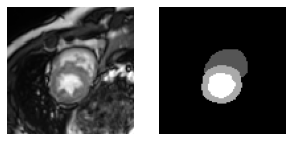

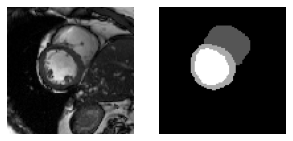

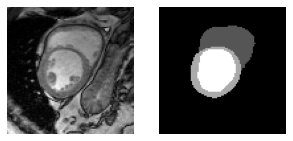

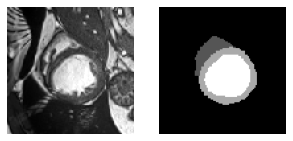

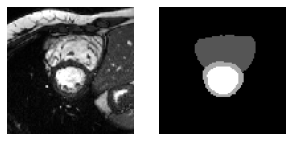

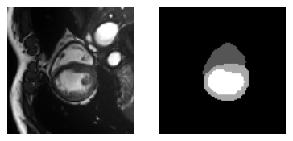

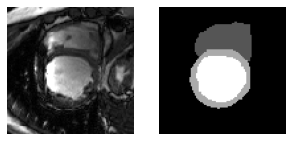

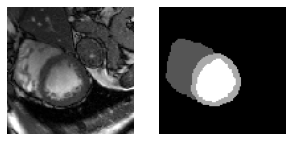

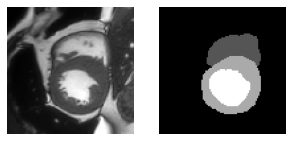

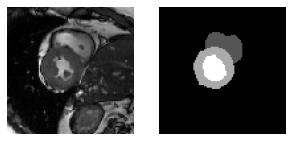

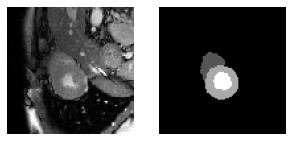

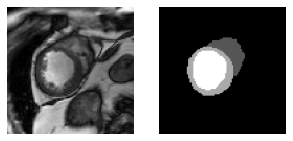

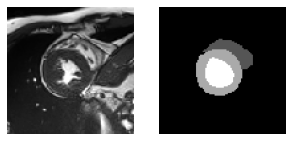

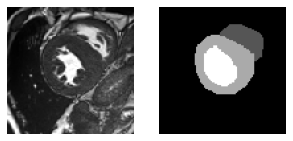

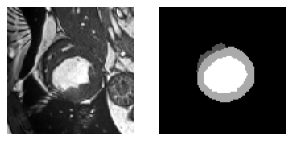

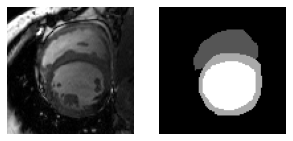

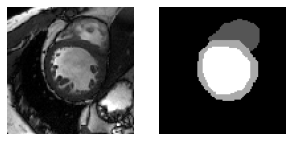

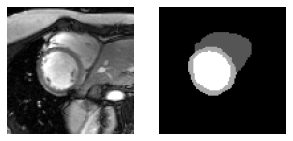

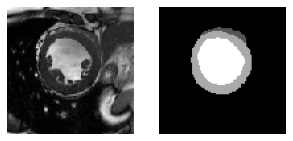

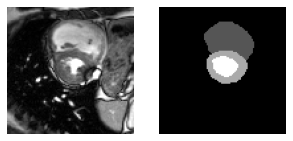

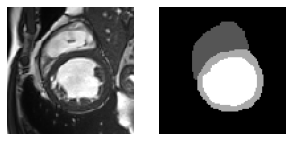

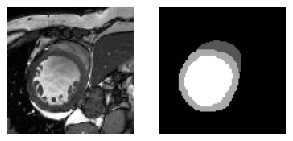

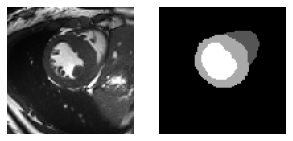

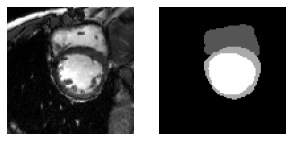

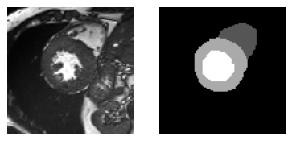

In [6]:
from torch.utils.data import DataLoader

data_path = './data/train'
num_workers = 4
batch_size = 4
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

# Fetch images and labels.  
for iteration, sample in enumerate(training_data_loader):
    img, mask = sample
 
    show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze()) #visualise all data in training set
    plt.pause(1)
    
    # Write your FORWARD below
    # Note: Input image to your model and ouput the predicted mask and Your predicted mask should have 4 channels
    
    
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize

### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [7]:
import numpy as np
from torch.autograd import Variable

torch.Size([2, 96, 96])


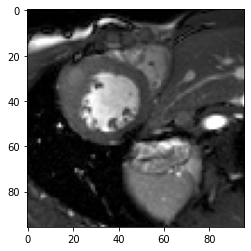

torch.Size([2, 96, 96])


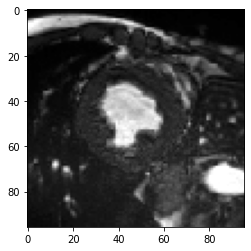

torch.Size([2, 96, 96])


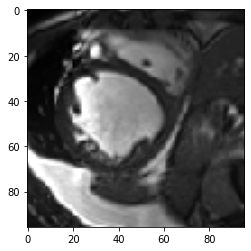

torch.Size([2, 96, 96])


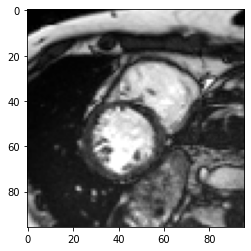

torch.Size([2, 96, 96])


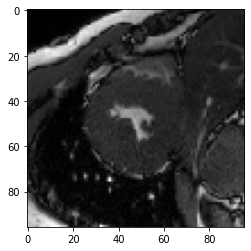

torch.Size([2, 96, 96])


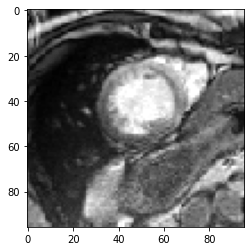

torch.Size([2, 96, 96])


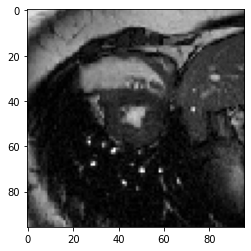

torch.Size([2, 96, 96])


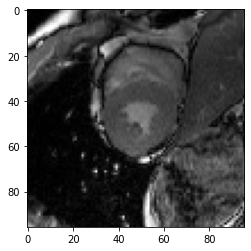

torch.Size([2, 96, 96])


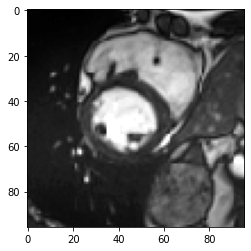

torch.Size([2, 96, 96])


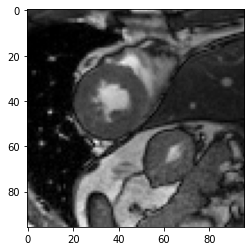

torch.Size([2, 96, 96])


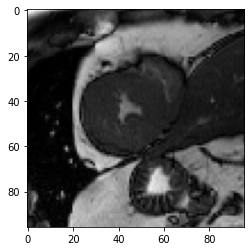

torch.Size([2, 96, 96])


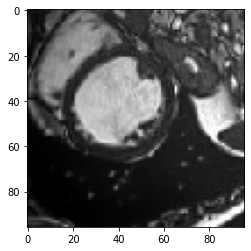

torch.Size([2, 96, 96])


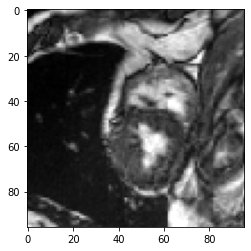

torch.Size([2, 96, 96])


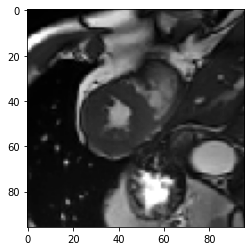

torch.Size([2, 96, 96])


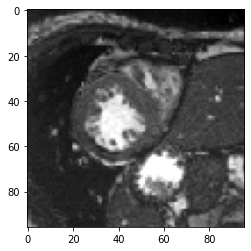

torch.Size([2, 96, 96])


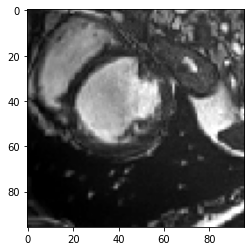

torch.Size([2, 96, 96])


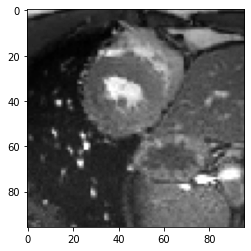

torch.Size([2, 96, 96])


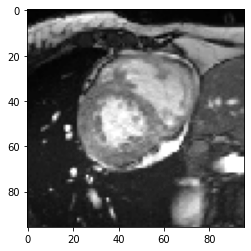

torch.Size([2, 96, 96])


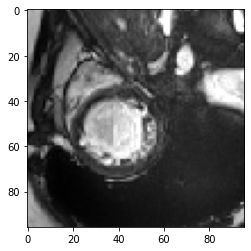

torch.Size([2, 96, 96])


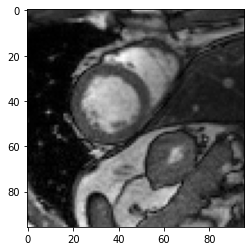

torch.Size([2, 96, 96])


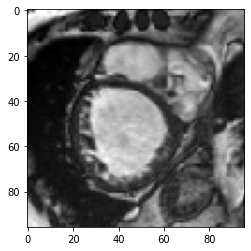

torch.Size([2, 96, 96])


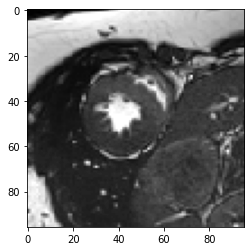

torch.Size([2, 96, 96])


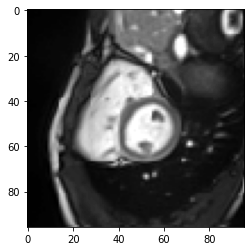

torch.Size([2, 96, 96])


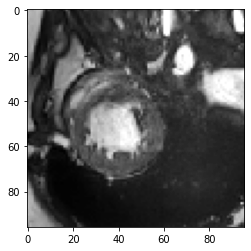

torch.Size([2, 96, 96])


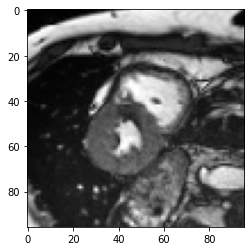

torch.Size([2, 96, 96])


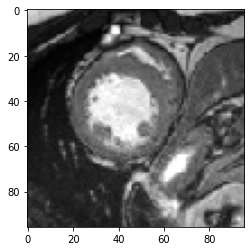

torch.Size([2, 96, 96])


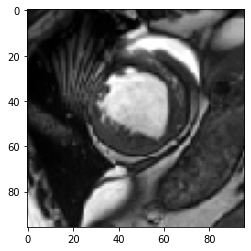

torch.Size([2, 96, 96])


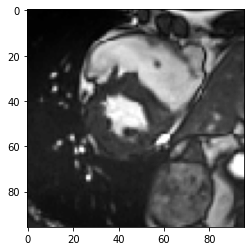

torch.Size([2, 96, 96])


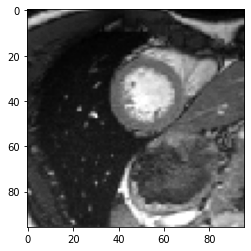

torch.Size([2, 96, 96])


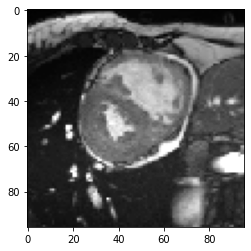

torch.Size([2, 96, 96])


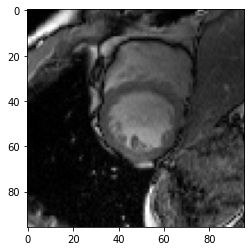

torch.Size([2, 96, 96])


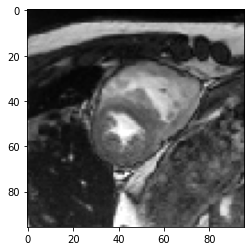

torch.Size([2, 96, 96])


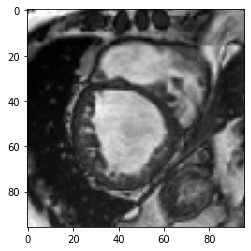

torch.Size([2, 96, 96])


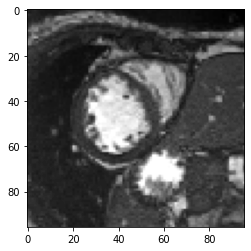

torch.Size([2, 96, 96])


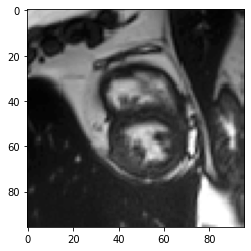

torch.Size([2, 96, 96])


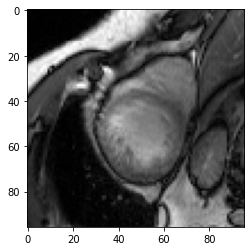

torch.Size([2, 96, 96])


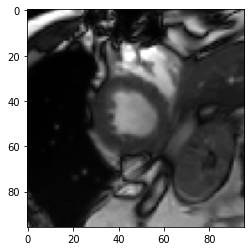

torch.Size([2, 96, 96])


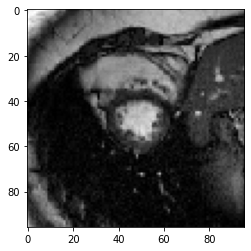

torch.Size([2, 96, 96])


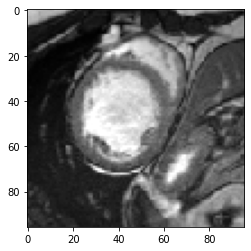

torch.Size([2, 96, 96])


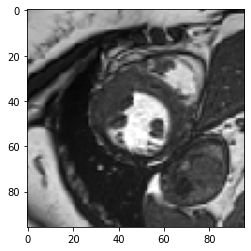

In [8]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    print(img.shape)

    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [9]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [10]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)
    print(files)
    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)
        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)
        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

In [11]:
submission_converter("test_results", "")

['_mask.png']


In [12]:
import cv2
import matplotlib.pyplot as plt
mask = cv2.imread("test_results\cmr121.png", cv2.IMREAD_UNCHANGED)
mask1 = (mask == 1)
mask2 = (mask == 2)
mask3 = (mask == 3)

In [13]:
mask1

False

TypeError: Invalid shape () for image data

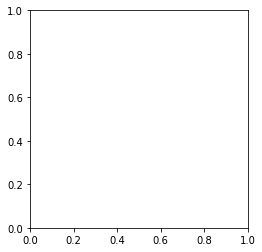

In [14]:
plt.imshow(mask1)